## Import Modules

In [4]:
# Standard libraries
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import re
from zipfile import ZipFile, ZIP_DEFLATED # for zipping of dataset because its too large

# ML/Deep Learning frameworks
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

## Data directory

In [5]:
DATA_DIRECTORY = './drive/Othercomputers/My MacBook Air/imageCaptionGenerator/dataset/'
WORKING_DIRECTORY = './drive/Othercomputers/My MacBook Air/imageCaptionGenerator/'

## Extract image features using pre-trained VGG16 model and store in a pickle file
**NOTE**: Only run this if you do not have features.pkl **and** features.pkl.zip file

[add remark on image dataset]

In [6]:
# ## load vgg16 model
# model = VGG16() 
# ## exclude last layer
# model = Model(inputs=model.inputs, outputs=model.layers[-2].output) 
# # print(model.summary())
# 
# ## extract features from image
# features = {}
# directory = os.path.join(DATA_DIRECTORY, 'Images')
# for img_name in tqdm(os.listdir(directory)):
#   ## load image from file
#   img_file = directory + '/' + img_name
#   image = load_img(img_file, target_size=(224,224))
#   ## reshape image to numpy array
#   image = img_to_array(image)
#   ## reshape data for model (VGG16 takes in 4d array)
#   image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
#   ## preprocess image for customized to vgg model
#   image = preprocess_input(image)
#   ## extract features
#   feature = model.predict(image, verbose=0) # toggle off any other display
#   ## get image ID
#   image_id = img_name.split('.')[0] # first index after splitting image name 
#   ## store features
#   features[image_id] = feature


# ## Store features in pickle to avoid re-downloading
# pickle.dump(features, open(os.path.join(WORKING_DIRECTORY, 'features.pkl'), 'wb')) # write-binary

## Load features (of images) pickle file
**Note**: This should only be done if using raw file

In [7]:
# with open(os.path.join(WORKING_DIRECTORY, 'features.pkl'), 'rb') as f:
#   features = pickle.load(f)

## Uncomment to mount drive to use existing data stored locally

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

## [**DEFAULT**] Unzip and load features pickle file

In [9]:
with ZipFile(os.path.join(WORKING_DIRECTORY, 'features.pkl.zip'), 'r') as zipObj:
   ## Extract all the contents of zip file into current directory
   print("Note that this was done in google colab, current directory is /content which is where the features.pkl file will be located.")
   zipObj.extractall('./') 

with open('./features.pkl', 'rb') as f:
  features = pickle.load(f)

Note that this was done in google colab, current directory is /content which is where the features.pkl file will be located.


##  Then load captions file

In [10]:
with open(os.path.join(DATA_DIRECTORY, 'captions.txt'), 'r') as f:
  next(f) # ignore first line in captions.txt
  captions = f.read()

## Map image to captions

In [11]:
mapping = {}
for line in tqdm(captions.split('\n')):
  if len(line) < 2:
    continue
  ## split line by comma
  tokens = line.split(',')
  ## get id and caption
  image_id, caption = tokens[0].split('.')[0], ''.join(tokens[1:])

  ## group captions for same images tgt
  if image_id not in mapping:
    mapping[image_id] = [caption]
  else:
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
# len(mapping) # just quick check of image length

## Preprocess caption data

In [12]:
START_TAG = '<start> '
END_TAG = ' <end>'
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      ## convert to lowercase and remove trailing spaces
      caption = caption.lower().strip()
      ## remove special chars
      caption = re.sub("[^A-Za-z ]", "", caption)
      ## remove additional white spaces between words
      caption = re.sub("[ +]", " ", caption)
      ## indicate start and end tag
      caption = START_TAG + caption + END_TAG
      ## update
      captions[i] = caption

## Testing result of preprocessing [optional]

In [13]:
print("Preprocessed: ", mapping['109202756_b97fcdc62c'])
clean(mapping)
print("Processed: ", mapping['109202756_b97fcdc62c'])

Preprocessed:  ['A woman dressed in a blue jacket and blue jeans rides a brown horse near a frozen lake and snow-covered mountain .', 'A woman in a blue jacket rides a brown pony near water .', 'A woman rides a horse near a frozen lake in the wintertime .', 'A young blond woman sitting atop a brown draft horse in the snowy mountains .', 'Woman n blue jacket sits on daft horse near a frozen lake .']
Processed:  ['<start> a woman dressed in a blue jacket and blue jeans rides a brown horse near a frozen lake and snowcovered mountain  <end>', '<start> a woman in a blue jacket rides a brown pony near water  <end>', '<start> a woman rides a horse near a frozen lake in the wintertime  <end>', '<start> a young blond woman sitting atop a brown draft horse in the snowy mountains  <end>', '<start> woman n blue jacket sits on daft horse near a frozen lake  <end>']


## Get all captions

In [14]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)
print(len(all_captions))

40455


## Tokenizing captions

In [15]:
tokenizer = Tokenizer()
## map knowledge of words to a unique number/id
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1 # note index starts from 1


## Find longest length of caption

In [16]:
max_length_caption = max(len(caption.split()) for caption in all_captions)
max_length_caption

37

## Split data into Train & Test set
Standard 9:1 ratio

update: run more epochs?

In [17]:
all_keys = list(mapping.keys())
split = int(len(all_keys) * 0.9)
train_data = all_keys[:split]
test_data = all_keys[split:]

## Data generator to get data in batches

In [18]:
def data_generator(train_keys, img_to_captions_map, img_features, tokenizer, max_length_caption, vocab_size, batch_size):
  X1, X2, y = [], [], []
  curr = 0
  while True:
    for key in train_keys:
      curr += 1
      captions = img_to_captions_map[key]
      for caption in captions:
        encoded = tokenizer.texts_to_sequences([caption])[0] # note takes in a list
        ## iterative split into input and output for LSTM model
        for i in range(1, len(encoded)): # start from <start> tag onwards
          in_, out_ = encoded[:i], encoded[i]
          in_ = pad_sequences([in_], maxlen=max_length_caption)[0]
          # print(in_)
          # break
          out_ = to_categorical([out_], num_classes=vocab_size)[0]

          X1.append(features[key][0])
          X2.append(in_)
          y.append(out_)
      if curr == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = [], [], []
        curr = 0

## CNN-LSTM Model

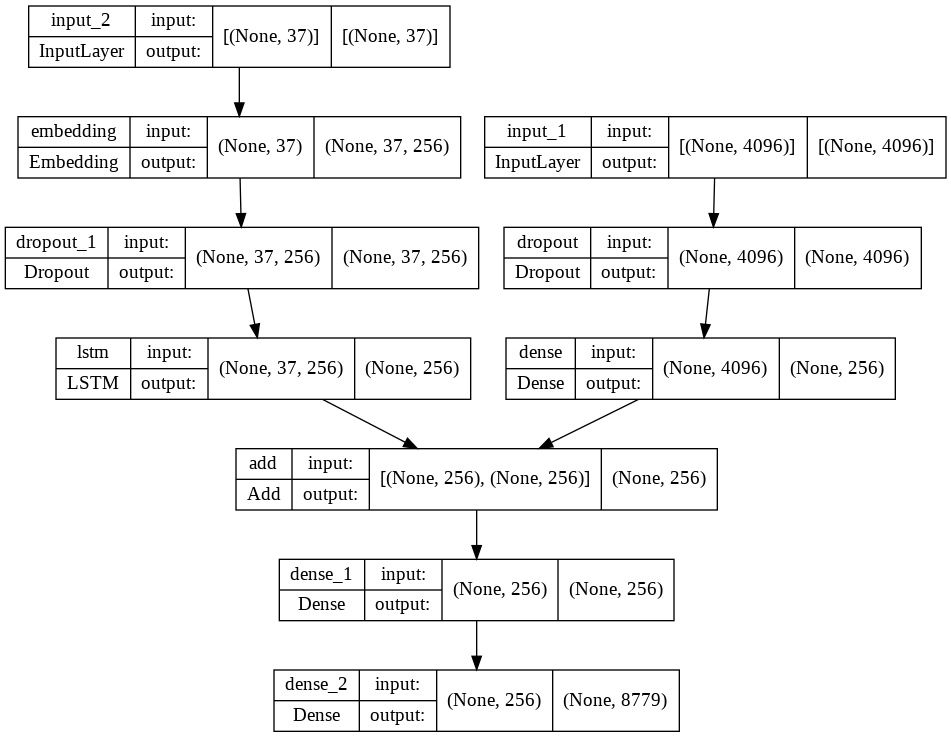

In [19]:
"""Encoder"""
## image layer
inputs1 = keras.layers.Input(shape=(4096,))
img_layer = keras.layers.Dropout(0.4)(inputs1)
img_layer = keras.layers.Dense(256, activation="relu")(img_layer)
## caption layer
inputs2 = keras.layers.Input(shape=(max_length_caption,))
cap_layer = keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
cap_layer = keras.layers.Dropout(0.4)(cap_layer)
cap_layer = keras.layers.LSTM(256)(cap_layer)

"""Decoder"""
decoder = keras.layers.add([img_layer, cap_layer])
decoder = keras.layers.Dense(256, activation="relu")(decoder)
outputs = keras.layers.Dense(vocab_size, activation="softmax")(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss="categorical_crossentropy", optimizer="adam")

## Visualise the model
plot_model(model, show_shapes=True)